# Prevendo Churn de clientes
## Desenvolvendo modelo de Machine Learning

### Parte 0: preparação do ambiente

In [52]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

### Parte 1: Exploratory Data Analysis

In [53]:
class EDA:
    def __init__(self, data: pd.DataFrame, target_col: str) -> None:
        self.data = data
        self.target_col = target_col

    def describe(self) -> None:
        print(self.data.describe())
        print(self.data.isna().sum())

    def info(self) -> None:
        print(self.data.info())
        print("Shape: ", self.data.shape)
        print("Value Counts of target: ", self.data[self.target_col].value_counts())        

    def plot(self, kind: str, x: str, y: str) -> None:
        self.data.plot(kind=kind, x=x, y=y)
        plt.show()

    def basic_plots(self, figsize=(10,5)) -> None:
        for column in self.data.columns:
            if column == self.target_col:
                continue
            if self.data[column].dtype in ['int64', 'float64']:
                fig, axs = plt.subplots(1,2, figsize=figsize)
                sns.histplot(self.data[column], kde=True, ax=axs[0])
                sns.boxplot(x=self.target_col, y=column, data=self.data, ax=axs[1])
                axs[0].set_title(f'Distribution by {column}')
                axs[0]
                axs[1].set_title(f'{column} vs {self.target_col}')
                fig.show()
            else:
                fig, axs = plt.subplots(1,2, figsize=figsize)
                sns.countplot(x=column, data=self.data, ax=axs[0])
                sns.countplot(x=column, data=self.data, hue=self.target_col, ax=axs[1])
                axs[0].set_title(f'Distribution by {column}')
                axs[1].set_title(f'{column} vs {self.target_col}')
                fig.show()

In [54]:
data = pd.read_csv('dataset.csv')
data.head()

,Idade,UsoMensal,Plano,SatisfacaoCliente,TempoContrato,ValorMensal,Churn
0,56,52,Premium,1,Curto,75.48,0
1,69,65,Basico,4,Curto,79.25,0
2,46,76,Standard,3,Longo,183.56,0
3,32,42,Basico,2,Longo,162.50,0
4,60,74,Standard,2,Longo,186.23,1


In [55]:
eda = EDA(data, 'Churn')
eda.describe()

             Idade   UsoMensal  SatisfacaoCliente  ValorMensal        Churn
count  1000.000000  1000.00000        1000.000000  1000.000000  1000.000000
mean     46.247000    48.97700           3.035000   124.137860     0.391000
std      16.288072    29.22517           1.418375    43.176829     0.488219
min      18.000000     0.00000           1.000000    50.000000     0.000000
25%      33.000000    24.00000           2.000000    86.440000     0.000000
50%      46.000000    48.00000           3.000000   123.425000     0.000000
75%      60.250000    74.00000           4.000000   160.837500     1.000000
max      74.000000    99.00000           5.000000   199.930000     1.000000
Idade                0
UsoMensal            0
Plano                0
SatisfacaoCliente    0
TempoContrato        0
ValorMensal          0
Churn                0
dtype: int64


In [56]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Idade              1000 non-null   int64  
 1   UsoMensal          1000 non-null   int64  
 2   Plano              1000 non-null   object 
 3   SatisfacaoCliente  1000 non-null   int64  
 4   TempoContrato      1000 non-null   object 
 5   ValorMensal        1000 non-null   float64
 6   Churn              1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB
None
Shape:  (1000, 7)
Value Counts of target:  Churn
0    609
1    391
Name: count, dtype: int64


/tmp/ipykernel_9157/2696092076.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9157/2696092076.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9157/2696092076.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9157/2696092076.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9157/2696092076.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_9157/2696092076.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


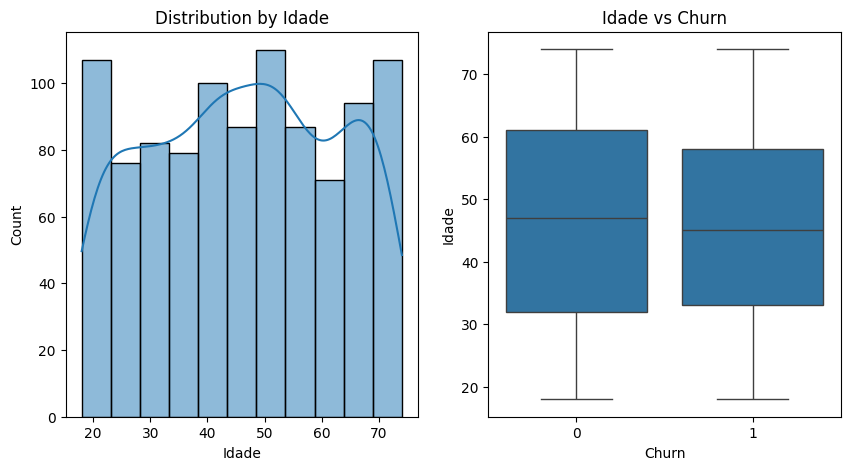

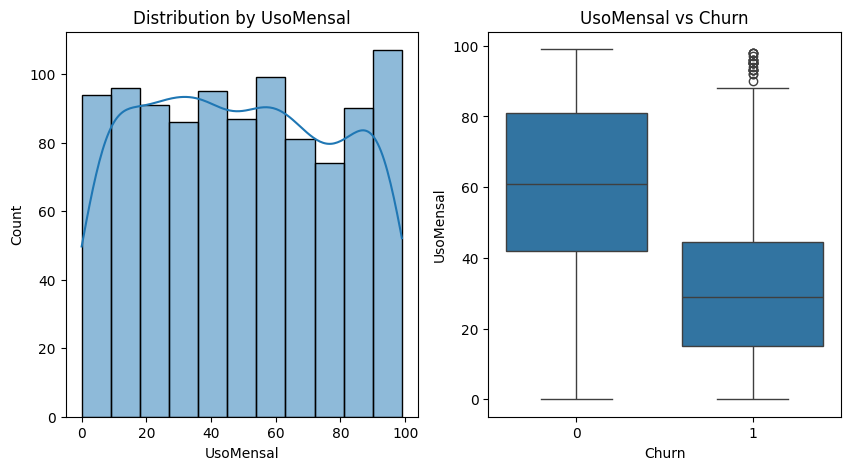

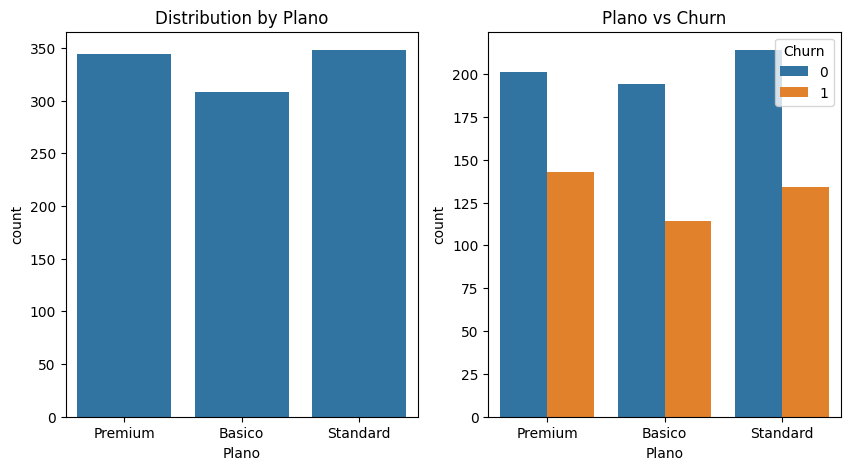

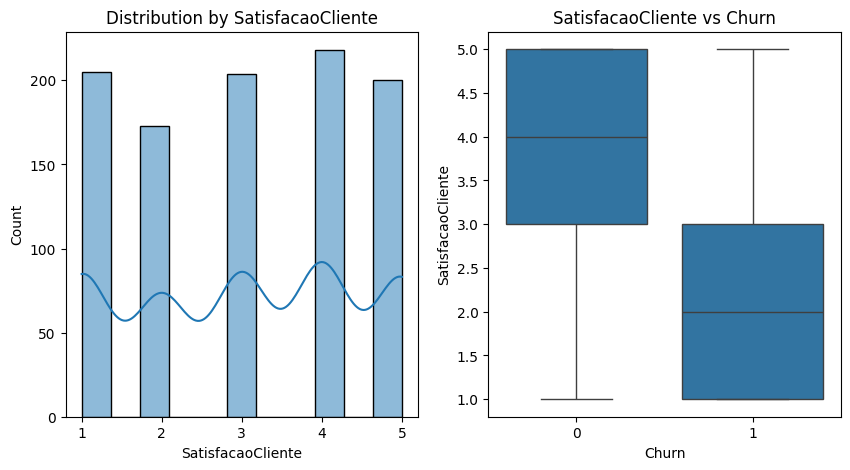

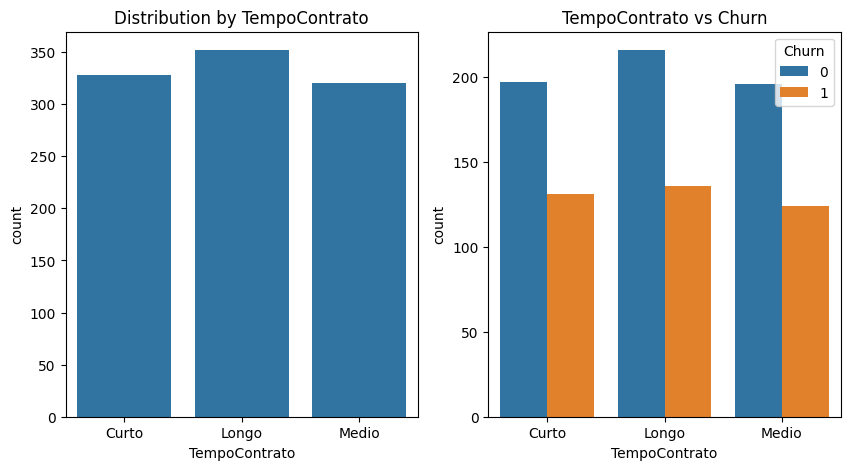

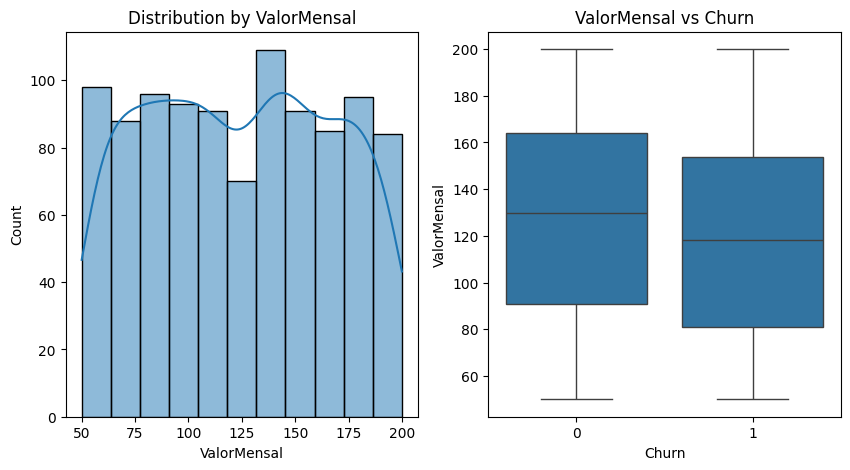

In [57]:
eda.basic_plots()

### Parte 2: Tratamento inicial dos dados

In [58]:
def split_dataset(data: pd.DataFrame, target_col: str, test_size=0.2, random_state=None) -> tuple:
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [59]:
X_train, X_test, y_train, y_test = split_dataset(data, 'Churn', test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 6), (300, 6), (700,), (300,))

In [60]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
print(categorical_cols)
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(X_train[categorical_cols])

Index(['Plano', 'TempoContrato'], dtype='object')


OneHotEncoder(sparse_output=False)

In [61]:
X_train_cat = pd.DataFrame(encoder.transform(X_train[categorical_cols]))
X_test_cat = pd.DataFrame(encoder.transform(X_test[categorical_cols]))
X_train_cat.columns = encoder.get_feature_names_out(categorical_cols)
X_test_cat.columns = encoder.get_feature_names_out(categorical_cols)

In [62]:
X_train_preprocessed_cat = pd.concat([X_train.drop(categorical_cols, axis=1).reset_index(drop=True), X_train_cat], axis=1)
X_test_preprocessed_cat = pd.concat([X_test.drop(
    categorical_cols, axis=1).reset_index(drop=True), X_test_cat], axis=1)

In [63]:
X_train_preprocessed_cat.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,65,80,4,174.10,0.0,0.0,1.0,0.0,0.0,1.0
1,49,18,3,101.59,1.0,0.0,0.0,0.0,1.0,0.0
2,19,91,4,87.93,1.0,0.0,0.0,0.0,0.0,1.0
3,52,0,1,90.74,0.0,0.0,1.0,0.0,1.0,0.0
4,62,60,1,134.59,1.0,0.0,0.0,1.0,0.0,0.0


In [64]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
scaler = StandardScaler()
scaler.fit(X_train_preprocessed_cat[numeric_cols])

Index(['Idade', 'UsoMensal', 'SatisfacaoCliente', 'ValorMensal'], dtype='object')


StandardScaler()

In [65]:
X_train_num = pd.DataFrame(scaler.transform(X_train_preprocessed_cat[numeric_cols]))
X_test_num = pd.DataFrame(scaler.transform(X_test_preprocessed_cat[numeric_cols]))
X_train_num.columns = numeric_cols
X_test_num.columns = numeric_cols
print(X_train_num.head())

      Idade  UsoMensal  SatisfacaoCliente  ValorMensal
0  1.180292   1.069020           0.676895     1.130872
1  0.178225  -1.055509          -0.029255    -0.544723
2 -1.700652   1.445952           0.676895    -0.860385
3  0.366112  -1.672308          -1.441554    -0.795450
4  0.992405   0.383688          -1.441554     0.217856


In [66]:
X_train_preprocessed_cat[numeric_cols] = X_train_num
X_test_preprocessed_cat[numeric_cols] = X_test_num

In [67]:
X_train_preprocessed = X_train_preprocessed_cat
X_test_preprocessed = X_test_preprocessed_cat

display(X_train_preprocessed.head())
display(X_test_preprocessed.head())

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,1.180292,1.069020,0.676895,1.130872,0.0,0.0,1.0,0.0,0.0,1.0
1,0.178225,-1.055509,-0.029255,-0.544723,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.700652,1.445952,0.676895,-0.860385,1.0,0.0,0.0,0.0,0.0,1.0
3,0.366112,-1.672308,-1.441554,-0.795450,0.0,0.0,1.0,0.0,1.0,0.0
4,0.992405,0.383688,-1.441554,0.217856,1.0,0.0,0.0,1.0,0.0,0.0


,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,-0.635955,1.274619,-0.029255,1.516090,0.0,0.0,1.0,0.0,0.0,1.0
1,0.929775,-0.610043,0.676895,1.198580,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.387505,-0.370177,-0.735404,0.323000,1.0,0.0,0.0,1.0,0.0,0.0
3,-1.262247,1.548752,0.676895,0.871364,0.0,0.0,1.0,1.0,0.0,0.0
4,1.493438,0.726354,-1.441554,-1.544164,0.0,1.0,0.0,1.0,0.0,0.0


### Parte 3: Primeiro modelo

In [68]:
model_v1 = RandomForestClassifier(random_state=42)

In [69]:
model_v1.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [70]:
y_pred = model_v1.predict(X_test_preprocessed)

In [71]:
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

In [72]:
print(f'Accuracy: {accuracy}', end='\n\n')
print(classification)

Accuracy: 0.7966666666666666

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       182
           1       0.74      0.74      0.74       118

    accuracy                           0.80       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.80      0.80      0.80       300



### Parte 4: Validação Cruzada

In [73]:
cv_scores = cross_val_score(model_v1, X_train_preprocessed, y_train, cv=5)
print(cv_scores)

[0.75714286 0.76428571 0.75       0.71428571 0.70714286]


Não houve muita discrepância entre os scores, logo os dados não possuem discrepância significativa

### Parte 5: Otimização de hiperparâmetros

In [74]:
params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid = params,  
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [75]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'max_depth': 5,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.7542857142857143)

In [76]:
model_v2 = RandomForestClassifier(random_state=42, **best_params)
model_v2.fit(X_train_preprocessed, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

In [77]:
y_pred_v2 = model_v2.predict(X_test_preprocessed)
accuracy_v2 = accuracy_score(y_test, y_pred_v2)
classification_v2 = classification_report(y_test, y_pred_v2)

In [78]:
print(f'Accuracy: {accuracy_v2}', end='\n\n')
print(classification_v2)

Accuracy: 0.81

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       182
           1       0.80      0.69      0.74       118

    accuracy                           0.81       300
   macro avg       0.81      0.79      0.80       300
weighted avg       0.81      0.81      0.81       300



### Parte 6: Automatizando a análise básica do modelo

In [79]:
class Report:
    def __init__(self, model, X_test, y_test) -> None:
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def accuracy(self) -> float:
        return accuracy_score(self.y_test, self.model.predict(self.X_test))
    
    def confusion_matrix(self) -> np.ndarray:
        return confusion_matrix(self.y_test, self.model.predict(self.X_test))
    
    def report(self) -> str:
        return classification_report(self.y_test, self.model.predict(self.X_test))
    
    def cross_val_score(self, cv=5) -> list:
        return cross_val_score(self.model, self.X_test, self.y_test, cv=cv)

In [94]:
from typing import Self


class SKLearnModelSelection:
    def __init__(self, models: list, selector: str='grid_search',
                 random_state: int | None = None) -> None:
        self.models = [model(random_state=random_state) for model in models]
        self.selector = selector
        self.random_state = random_state
        self.best_model = None
        self.best_params = None
    
    def compile(self, X_train,
                y_train, 
                cv: int | None = 5) -> Self:
        
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv
        if self.selector == 'grid_search':
            self.selector = GridSearchCV
        elif self.selector == 'random_search':
            self.selector = RandomizedSearchCV
        else:
            raise NotImplementedError('Selector not implemented')
        
        return self
        
    def fit(self, params, scoring: str = 'accuracy', n_jobs: int = -1, keep_all_models: bool=False) -> Self:
        self.params = params
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.best_score = 0
        if keep_all_models:
            self.all_models_ = []
        for model, param in zip(self.models, self.params):
            selector = self.selector(
                model,
                param_grid = param,
                cv=self.cv,
                scoring=scoring,
                n_jobs=n_jobs
            )
            selector.fit(self.X_train, self.y_train)
            print(f'Model: {type(model)}','=====================', f'Best estimator: {selector.best_estimator_}', f'Best params: {selector.best_params_}',
                  f'{selector.best_score_}', sep='\n\n')
            if keep_all_models: 
                self.all_models_.append((selector.best_estimator_, selector.best_params_, selector.best_score_))
            else:
                if selector.best_score_ > self.best_score:
                    self.best_score = selector.best_score_
                    self.best_model = selector.best_estimator_
                    self.best_params = selector.best_params_

        return self
        

In [97]:
params = [
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4]
    },
    {
        'loss': ['log_loss', 'exponential'],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [1, 3, 5, 10],
        'max_leaf_nodes': [None, 5, 10, 15],
    }, 
    {
        'estimator': [RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42)],
        'n_estimators': [25, 50, 100],
        'learning_rate': [0.5, 1, 2]
    }
]


In [98]:
model_selector = SKLearnModelSelection([RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, XGBClassifier], random_state=42).compile(X_train_preprocessed, y_train).fit(params)

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


Best estimator: RandomForestClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

0.7542857142857143
Model: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


Best estimator: GradientBoostingClassifier(learning_rate=0.05, loss='exponential', max_depth=5,
                           random_state=42)

Best params: {'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 5, 'max_leaf_nodes': None, 'n_estimators': 100}

0.7757142857142857


/home/fabricio/Documents/programs/tutorials/DSA/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/fabricio/Documents/programs/tutorials/DSA/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/fabricio/Documents/programs/tutorials/DSA/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/fabricio/Documents/programs/tutorials/DSA/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAM

Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>


Best estimator: AdaBoostClassifier(estimator=GradientBoostingClassifier(random_state=42),
                   learning_rate=2, random_state=42)

Best params: {'estimator': GradientBoostingClassifier(random_state=42), 'learning_rate': 2, 'n_estimators': 50}

0.7485714285714286


In [99]:
model_selector.best_model, model_selector.best_params, model_selector.best_score

(GradientBoostingClassifier(learning_rate=0.05, loss='exponential', max_depth=5,
                            random_state=42),
 {'learning_rate': 0.05,
  'loss': 'exponential',
  'max_depth': 5,
  'max_leaf_nodes': None,
  'n_estimators': 100},
 0.7757142857142857)

In [100]:
report = Report(model_selector.best_model, X_test_preprocessed, y_test)

In [101]:
report.accuracy()

0.81

In [102]:
report.confusion_matrix()

array([[147,  35],
       [ 22,  96]])

In [104]:
print(report.report())

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       182
           1       0.73      0.81      0.77       118

    accuracy                           0.81       300
   macro avg       0.80      0.81      0.80       300
weighted avg       0.82      0.81      0.81       300



Conclusão: para random_state = 42, o melhor modelo foi GradientBoostingClassifier

### Parte 7: Criando o pipeline

In [116]:
from sklearn.compose import ColumnTransformer


model_v3 = GradientBoostingClassifier(random_state=42, **model_selector.best_params)
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse_output=False), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols),
])

pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('model', model_v3)
])

In [117]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['Plano', 'TempoContrato'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['Idade', 'UsoMensal', 'SatisfacaoCliente', 'ValorMensal'], dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            loss='exponential', max_depth=5,
                                            random_state=42))])

In [119]:
print(Report(pipeline, X_test, y_test).report())

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       182
           1       0.73      0.82      0.78       118

    accuracy                           0.81       300
   macro avg       0.80      0.81      0.81       300
weighted avg       0.82      0.81      0.81       300



### Salvando o modelo

In [120]:
joblib.dump(pipeline, 'model.pkl')

['model.pkl']